In [1]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os
import pickle
import random
from scipy.signal import savgol_filter
import h5py
plt.ioff()

#load the graph and the dictionary
####
#CAREFUL - put these files from kagome_embedding.ipynb in the correct folder
####
#load the graph and the dictionary
# final_qubit_dictionary = np.load("../data/dict_qbit_to_lattice_periodic.npy", allow_pickle=True).flat[0]
# Kag_graph = pickle.load(open('../data/Kag_graph_periodic.pickle', 'rb'))

final_qubit_dictionary = np.load("./lattice_files_v1/dict_qbit_to_lattice_periodic.npy", allow_pickle=True).flat[0]
# Kag_graph = pickle.load(open('../data/Kag_graph_periodic.pickle', 'rb'))
# unit_cells = np.load("../data/unitcells.npy", allow_pickle=True).flat[0]
# unit_cells_down = np.load("../data/unitcells_down.npy", allow_pickle=True).flat[0]

#test that it works
#nx.draw(Kag_graph, final_qubit_dictionary)


# Data

Import some data - first, the different h/J accessible.

In [2]:
# folder_global = "../data_prathus_runs/APQ1/raw"
folder_global = "../../data_prathus_runs/APQ2-prototype/raw"
# folder_global = "../data_prathus_runs/"

dict_h = {}
Jmax = 0.83
mainfolder = list(Path(folder_global).glob('*'))
#mainfolder = list(Path('./data/raw_apq_zx').glob('*'))
for foldername in mainfolder:
    h1 = str(foldername).split('/')[-1].split('=')[-1]
    if h1 != ".DS_Store" and h1 != ".DS_Store:Zone.Identifier":
        #print("h1=",h1)
        hJtag = "{:.3f}".format(float(h1)/Jmax)
        dict_h.update({hJtag:h1})
print("various h/J in folder: " + folder_global)
print(dict_h.keys())

various h/J in folder: ../../data_prathus_runs/APQ2-prototype/raw
dict_keys(['0.000', '1.594', '0.398', '0.598', '1.793', '1.394', '1.992', '1.195', '0.996', '0.199', '2.191', '2.390', '0.797'])


In [3]:
#file_name = "./data/J=1.0__h1,h2,k2,s=1.04,0.52,-2.0,0__04-10-23__18-08-54.npz"
#file_name = "./data/J=1.0__h1,h2,k2,s=3.04,1.52,-2.0,0__04-10-23__18-09-45.npz"
# folder = "../data_prathus_runs/APQ1/raw/h1=0.6613701696385046/s=0.7"
folder = folder_global + "/h1=" + dict_h['2.004'] + "/s=0.2"
# folder = folder_global + "/h1=" + dict_h['2.004'] + "/s=0.7"
# folder = "../data_prathus_runs/APQ1/raw/h1=1.9841105089155138/s=0.7"
#folder = "../data_prathus_runs/APQ1/raw/h1=0.0/s=0.7"


#folders from the raw
# folder = "../data_prathus_runs/periodic Kagome fwd2/raw/h1=1.2800000000000002"
# folder = "../data_prathus_runs/periodic Kagome fwd5/raw/h1=2.88"


mainfolder = list(Path(folder).glob('*'))
#mainfolder = list(Path('./data/raw_apq_zx').glob('*'))

reps = 0
folders_to_open = []
if len(mainfolder) != 0:
    print("success in finding this folder")
else:
    print('problem')
for foldername in mainfolder:
    if str(foldername)[-4:] == ".npz":
        #print(foldername)
        reps += 1
        folders_to_open.append(foldername)

# def open_file(path):
    
#     file=np.load(path)
    
#     resp=file['resp']
#     paramsarray=file['paramsarray']
#     missingqs=file['missingqs']
#     twochains=file['twochains']
#     nodes=file['final_nodes']
    
#     return resp,paramsarray,missingqs,twochains,nodes

all_configs = []
all_energies = []
for k in range(len(folders_to_open)):
    file=np.load(folders_to_open[k])
    resps = file['resp']

    for i in range(len(resps)):
        frequency = resps[i][2]
        for freq in range(frequency):
            all_configs.append(resps[i][0])
            all_energies.append(resps[i][1])

all_configs = np.array(all_configs)
file2=np.load(folders_to_open[0])
qubit_variables = np.array(file2["final_nodes"])

KeyError: '2.004'

# plot the periodic lattice and spin response

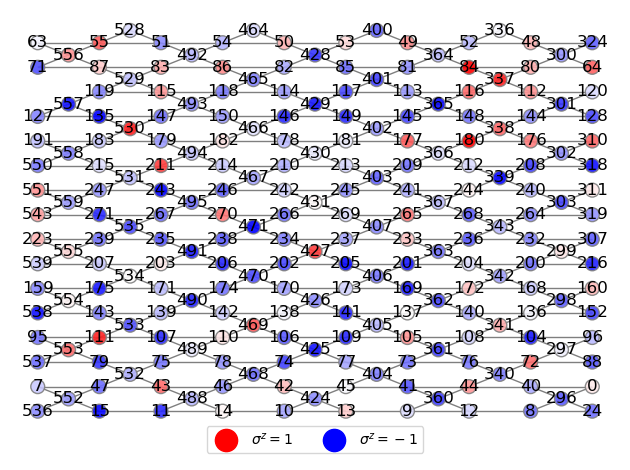

In [20]:
#plot the Kagome lattice graph with a certain response in mind
#this is for an average on each site to be shown with spatial resolution
avg_config = np.mean(all_configs, axis = 0)
# avg_config = all_configs[9000]
#--- 1 -- 
#make a generic response
dict_response = {}
m = 0
for key in final_qubit_dictionary.keys():
    dict_response.update({key:avg_config[m]})
    m += 1

cvals  = [-1, 0, 1]
colors = ["blue","white","red"]

import matplotlib.colors as mc

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = mc.LinearSegmentedColormap.from_list("", tuples)

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
qubits_val = []
qubit_colors = []
for i in range(len(final_qubit_dictionary)):
    qubit_colors.append((dict_response[test_response_qubits[i]] + 1)/2)
    qubits_val.append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 1.0:
    #     qubits_val[0].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == -1.0:
    #     qubits_val[1].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 0.0:
    #     qubits_val[2].append(test_response_qubits[i])

#draw the graph with the specific nodes in red or blue

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "red", r'$\sigma^z = -1$' : "blue"
#, r'absent' : "white"
}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[-2],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [-2], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[2], node_color="white", **options, ax=ax)
nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val, node_color=qubit_colors, **options, ax=ax, cmap = cmap)

label_list = {}
for key in final_qubit_dictionary.keys():
    label_list.update({key:str(key)})

nx.draw_networkx_labels(Kag_graph, final_qubit_dictionary,labels = label_list)

# edges
nx.draw_networkx_edges(Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,0.0),loc='lower center', ncol=3, fontsize = 10)


plt.tight_layout()
plt.axis("off")
plt.show()

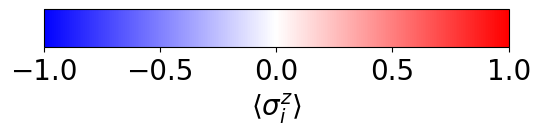

In [8]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)
cbar.set_label( label=r'$\langle \sigma_i^z \rangle$', fontsize=20)
plt.show()

# Perform Fourier transforms

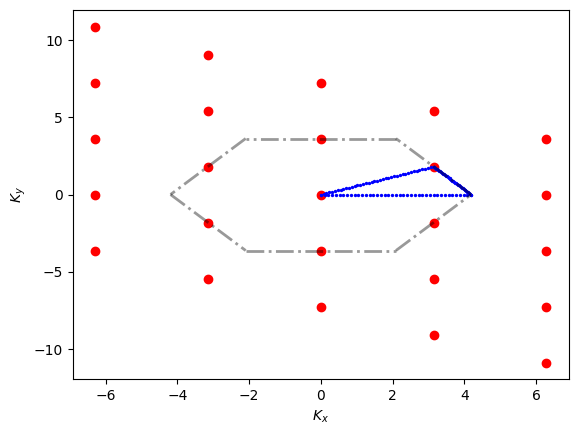

In [42]:
def momentum_grid_kagome(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-1, 1, N)
        points2 = np.linspace(-1, 1, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def momentum_grid(N):
        # Reciprocal lattice vectors
        b1 = 2*np.pi * np.array([1,0])
        b2 = 2*np.pi * np.array([0, 1])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-0.5, 0.5, N)
        points2 = np.linspace(-0.5, 0.5, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals

def path_Kagome(N):
    # Define the reciprocal lattice vectors
    b1 = (2*np.pi/3)*np.array([1, -1/np.sqrt(3)])
    b2 = (2*np.pi/3)*np.array([1, 1/np.sqrt(3)])

    # Define the high-symmetry points
    Gamma = np.array([0, 0])
    #K = (4*np.pi/9)*np.array([1, 1/np.sqrt(3)])
    #G = (2*np.pi/3)*np.array([1, 0])
    K = (4*np.pi/3)*np.array([1, 0])
    G = (4*np.pi/3)*(np.array([1, 0]) + np.array([np.cos(2*np.pi/6), np.sin(2*np.pi/6)]))/2

    # Define the number of points between Gamma-K and K-Gamma'
    # Generate the path
    path = [Gamma]
    path += [Gamma + (i/N)*(K-Gamma) for i in range(1, N+1)]
    path += [K]
    path += [K + (i/N)*(G-K) for i in range(1, N+1)]
    path += [G]
    path += [G + (i/N)*(Gamma-G) for i in range(1, N+1)]

    # Convert the path to Cartesian coordinates
    path_cart = path
    kx_vals = []
    ky_vals = []
    for point in path_cart:
        kx_vals.append(point[0])
        ky_vals.append(point[1])

    return path_cart, kx_vals, ky_vals

def momentum_grid_kagome_scale(N, ascale):
        # Reciprocal lattice vectors
        b1 = 2*np.pi/ascale * np.array([1, -1/np.sqrt(3)])
        b2 = 2*np.pi/ascale * np.array([0, 2/np.sqrt(3)])

        # Generate a mesh of points in the range -0.5 to 0.5 for each reciprocal lattice vector
        points1 = np.linspace(-1, 1, N)
        points2 = np.linspace(-1, 1, N)
        mesh1, mesh2 = np.meshgrid(points1, points2)

        m1 = mesh1.flatten()
        m2 = mesh2.flatten()
        kx_vals = np.zeros(N**2)
        ky_vals = np.zeros(N**2)
        for i in range(N**2):
                kx_vals[i] = m1[i]*b1[0] + m2[i]*b2[0]
                ky_vals[i] = m1[i]*b1[1] + m2[i]*b2[1]

        total_K = []
        for i in range(N**2):
                total_K.append([kx_vals[i], ky_vals[i]])
        total_K = np.array(total_K)
        kx_vals = kx_vals.reshape(N,N)
        ky_vals = ky_vals.reshape(N,N)



        return total_K, kx_vals, ky_vals


#plot the scatter of the kx, ky points that have to be run over
total_K, kx_vals, ky_vals = momentum_grid_kagome(5)
#total_K, kx_vals, ky_vals = momentum_grid(41)
plt.scatter(kx_vals, ky_vals, label = '2D points', c = 'red')
total_K_again, kx, ky = path_Kagome(40)
plt.scatter(kx, ky, label = 'Line', c = 'blue', s = 2)

theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')
plt.show()

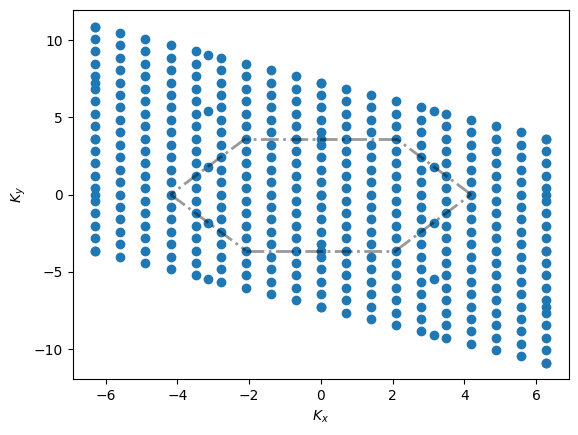

In [54]:
total_K_1, kx_vals, ky_vals = momentum_grid_kagome(5)
total_K_2, kx_vals, ky_vals = momentum_grid_kagome(19)
# plot_kx = np.concatenate((kx_vals, kx_vals_2))
# plot_ky = np.concatenate((ky_vals, ky_vals_2))
plot_K = np.concatenate((total_K_1, total_K_2))

plt.scatter(plot_K[:,0], plot_K[:,1])
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.xlabel(r'$K_x$')
plt.ylabel(r'$K_y$')
plt.show()

Doing the fourier transform of the *average* configuration

In [137]:
# total_K, kx_vals, ky_vals = momentum_grid_kagome(51)

# # structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
# S2_spin = np.zeros(len(total_K))

# #response_analyzed = best_array_dict
# avg_config = np.mean(all_configs, axis = 0)
# #avg_config = all_configs[10]
# #--- 1 -- 
# #make a generic response
# response_analyzed = {}
# m = 0
# for key in final_qubit_dictionary.keys():
#     response_analyzed.update({key:avg_config[m]})
#     m += 1

# for kp in range(len(total_K)):
#     val = 0
#     for q1 in final_qubit_dictionary.keys():
#         kpoint = total_K[kp]
#         r1 = final_qubit_dictionary[q1]
#         val += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
#     val = val/len(final_qubit_dictionary)
#     S2_spin[kp] = abs(val)


# #norm = plt.Normalize(0,len(test_response_qubits))
# cmap = plt.cm.get_cmap('gist_stern_r')
# plt.scatter(kx_vals, ky_vals, s=10, c=S2_spin, cmap=cmap)
# plt.colorbar()
# theta_list = [2*np.pi*i/6 for i in range(7)]
# lside = 4*np.pi/3
# for j in range(6):
#     plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
#      [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
# plt.xlabel(r'$K_x$')
# plt.ylabel(r'$K_y$')


In [64]:
path_Kagome(5)

([array([0, 0]),
  array([0.83775804, 0.        ]),
  array([1.67551608, 0.        ]),
  array([2.51327412, 0.        ]),
  array([3.35103216, 0.        ]),
  array([4.1887902, 0.       ]),
  array([4.1887902, 0.       ]),
  array([3.97935069, 0.36275987]),
  array([3.76991118, 0.72551975]),
  array([3.56047167, 1.08827962]),
  array([3.35103216, 1.45103949]),
  array([3.14159265, 1.81379936]),
  array([3.14159265, 1.81379936]),
  array([2.51327412, 1.45103949]),
  array([1.88495559, 1.08827962]),
  array([1.25663706, 0.72551975]),
  array([0.62831853, 0.36275987]),
  array([0., 0.])],
 [0,
  0.8377580409572781,
  1.6755160819145563,
  2.513274122871834,
  3.3510321638291125,
  4.1887902047863905,
  4.1887902047863905,
  3.979350694547071,
  3.7699111843077517,
  3.560471674068432,
  3.3510321638291125,
  3.141592653589793,
  3.141592653589793,
  2.5132741228718345,
  1.8849555921538759,
  1.2566370614359172,
  0.6283185307179586,
  0.0],
 [0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,


Average of S(q) over all the available configurations: this is needed for the full structure factor

In [56]:
def Sq_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    # total_K, kx_vals, ky_vals = momentum_grid_kagome(L_Kpoints)
    total_K_1, kx_vals, ky_vals = momentum_grid_kagome(5)
    total_K_2, kx_vals, ky_vals = momentum_grid_kagome(L_Kpoints)
    # plot_kx = np.concatenate((kx_vals, kx_vals_2))
    # plot_ky = np.concatenate((ky_vals, ky_vals_2))
    total_K = np.concatenate((total_K_1, total_K_2))

    structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    structure_factor_mK = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S_spin = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))

    num_reads = len(all_record_configs)

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})
        avg = 0.0
        #calculate_avg = False
        #if calculate_avg == True:
        #    for q1 in qubit_dictionary.keys():
        #        avg += response_analyzed[q1]
        #    avg = avg / len(qubit_dictionary)

        for kp in range(len(total_K)):
            val_K = 0
            val_mK = 0
            for q1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                r1 = qubit_dictionary[q1]
                val_K += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
                val_mK += np.exp(-1j*np.dot(kpoint, r1))*(response_analyzed[q1])
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += val_K
            structure_factor_mK[kp] += val_mK
            S_spin[kp] += abs(val_K)
            S2_spin[kp] += val_K*val_mK
        if k % (num_reads // 10) == 0:
            print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    structure_factor_mK = structure_factor / num_reads
    S_spin = S_spin / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, total_K[:,0], total_K[:,1], S_spin, S2_spin, structure_factor, structure_factor_mK
    

Calculate it over N points

In [57]:
numKpoints = 19
order = list(range(len(all_configs)))
random.shuffle(order)
feed_in_configs = all_configs[order[0:100]]
total_K, kx_vals, ky_vals, S_spin, S2_spin, structure_factor, structure_factor_mK = Sq_for_record(feed_in_configs, final_qubit_dictionary, qubit_variables, numKpoints)

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90


/tmp/ipykernel_403/4103236403.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_stern_r')


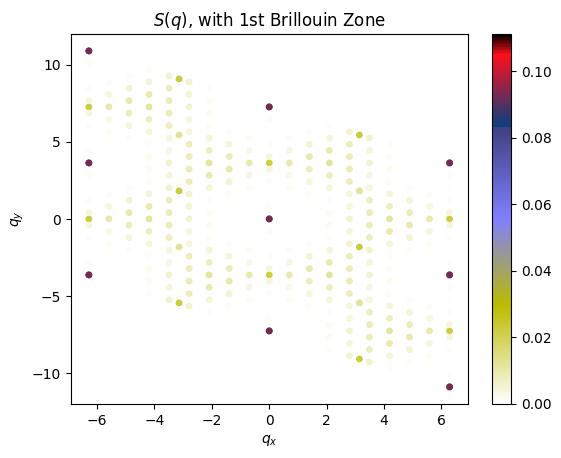

In [65]:
norm = plt.Normalize(0,(1/3)**2)
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ_spin = np.absolute(structure_factor)
finalSQ_spin = np.absolute(S2_spin)
#finalSQ = final_spin_Q2 - final_spin_Q**2
plt.scatter(kx_vals, ky_vals, s=15, c=finalSQ_spin, cmap=cmap, norm=norm)
plt.colorbar()
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
#for j in range(6):
#    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
#     [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
# total_K_again, kx, ky = path_Kagome(6)
# for i in range(len(total_K_again)):
#     plt.scatter(*total_K_again[i], color = 'black', s = 100, alpha = 0.1)
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$S(q)$, with 1st Brillouin Zone')
plt.show()

Interpolation Scheme


In [23]:
from scipy.interpolate import griddata
nk_init = 19
xlim = np.linspace(-2*np.pi, 2*np.pi, 4*(nk_init - 1) + 1)
ylim = np.linspace(-2*np.pi, 2*np.pi, 4*(nk_init - 1) + 1)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
total_K = []
for i in range(len(kx_vals)):
        total_K.append([kx_vals[i], ky_vals[i]])
total_K = np.array(total_K)
points = total_K
values = finalSQ_spin
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
#possible methods: nearest, square, cubic


#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
norm = plt.Normalize(0,np.max(values))

cmap = plt.cm.get_cmap('gist_stern_r')
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower', cmap = cmap, norm = norm)
plt.title('Nearest Interpolation of S(q) for Triangle OP')
plt.colorbar()
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
theta_list = [2*np.pi*i/6 for i in range(7)]
lside = 4*np.pi/3
for j in range(6):
    plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])], [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)

#total_K_again, kx, ky = path_Kagome(11)
#for i in range(20):
#    plt.scatter(*total_K_again[i], color = 'black', s = 5)
plt.gcf().set_size_inches(6, 6)
plt.show()

ValueError: different number of values and points

Line cut along the Gamma - K-M points

In [70]:
def line_BZ(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component

    total_K, kx_vals, ky_vals = path_Kagome(L_Kpoints)

    structure_factor = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    # structure_factor_mK = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S_spin = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    S3_spin = np.zeros(len(total_K))

    num_reads = len(all_record_configs)

    # angle_per_read = []

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})
        avg = 0.0
        #calculate_avg = False
        #if calculate_avg == True:
        #    for q1 in qubit_dictionary.keys():
        #        avg += response_analyzed[q1]
        #    avg = avg / len(qubit_dictionary)

        for kp in range(len(total_K)):
            val_K = 0
            val_mK = 0
            for q1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                r1 = qubit_dictionary[q1]
                val_K += np.exp(1j*np.dot(kpoint, r1))*(response_analyzed[q1])
                val_mK += np.exp(-1j*np.dot(kpoint, r1))*(response_analyzed[q1])
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += val_K
            # structure_factor_mK[kp] += val_mK
            S_spin[kp] += abs(val_K)
            S2_spin[kp] += val_K*val_mK
            S3_spin[kp] += abs(val_K*val_mK)
        if k % (num_reads // 10) == 0:
            print("Done with reads: ", k)

        

    structure_factor = structure_factor / num_reads
    # structure_factor_mK = structure_factor / num_reads
    S_spin = S_spin / num_reads
    S2_spin = S2_spin / num_reads
    S3_spin = S3_spin / num_reads

    return total_K, kx_vals, ky_vals, S_spin, S2_spin, S3_spin, structure_factor

angle for K point of S_q

In [22]:
def angle_K(all_record_configs, qubit_dictionary, qubit_variables):
    #L_Kpoints needs to be odd to see the q=0 component

    num_reads = len(all_record_configs)

    angle_per_read_at_K = []
    K = (4*np.pi/3)*np.array([1, 0])

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})

        val = 0.0 + 1j*0.0

        for q1 in qubit_dictionary.keys():
            r1 = qubit_dictionary[q1]
            # print(q1)
            # print(np.exp(1j*np.dot(K, r1))*(response_analyzed[q1]))
            val += np.exp(1j*np.dot(K, r1))*(response_analyzed[q1])
            # print(val)

        val = val/len(qubit_dictionary)

        angle_per_read_at_K.append(np.arctan2(np.real(val), np.imag(val)))
    return angle_per_read_at_K

In [50]:
list_K_angle = angle_K(all_configs, final_qubit_dictionary, qubit_variables)
bins_all = np.arange(-np.pi-2*np.pi/96, np.pi + 1, 2*np.pi/48)
histo_count, histo_bins = np.histogram(list_K_angle, bins = bins_all)

f.create_dataset("histo_bins", data = histo_bins)
f.create_dataset("histo_count", data = histo_count)

In [54]:
bins_all = np.arange(-np.pi-2*np.pi/96, np.pi + 1, 2*np.pi/48)
histo_count, histo_bins = np.histogram(list_K_angle, bins = bins_all)


(array([26, 25, 35, 31, 20, 32, 18, 26, 18, 26, 20, 11, 14, 12, 15, 16, 10,
        17,  9, 16,  5,  9,  9, 14, 16, 12, 14, 11, 16, 17, 17, 18, 24, 17,
        25, 21, 37, 25, 34, 28, 30, 33, 16, 25, 26, 28, 36, 31,  9,  0,  0,
         0,  0,  0,  0,  0]),
 array([-3.2070425 , -3.07614281, -2.94524311, -2.81434342, -2.68344372,
        -2.55254403, -2.42164434, -2.29074464, -2.15984495, -2.02894526,
        -1.89804556, -1.76714587, -1.63624617, -1.50534648, -1.37444679,
        -1.24354709, -1.1126474 , -0.9817477 , -0.85084801, -0.71994832,
        -0.58904862, -0.45814893, -0.32724923, -0.19634954, -0.06544985,
         0.06544985,  0.19634954,  0.32724923,  0.45814893,  0.58904862,
         0.71994832,  0.85084801,  0.9817477 ,  1.1126474 ,  1.24354709,
         1.37444679,  1.50534648,  1.63624617,  1.76714587,  1.89804556,
         2.02894526,  2.15984495,  2.29074464,  2.42164434,  2.55254403,
         2.68344372,  2.81434342,  2.94524311,  3.07614281,  3.2070425 ,
         3.3

Calculate line cut S(q) - note don't do too many points otherwise there will be spurious oscillations in Q

In [71]:
numKpoints = 40
feed_in_configs = all_configs[order[:100]]
total_K, kx_vals, ky_vals, S_spin, S2_spin, S3_spin, structure_factor = line_BZ(feed_in_configs, final_qubit_dictionary, qubit_variables, numKpoints)
print('done')

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90
done


Make some plots

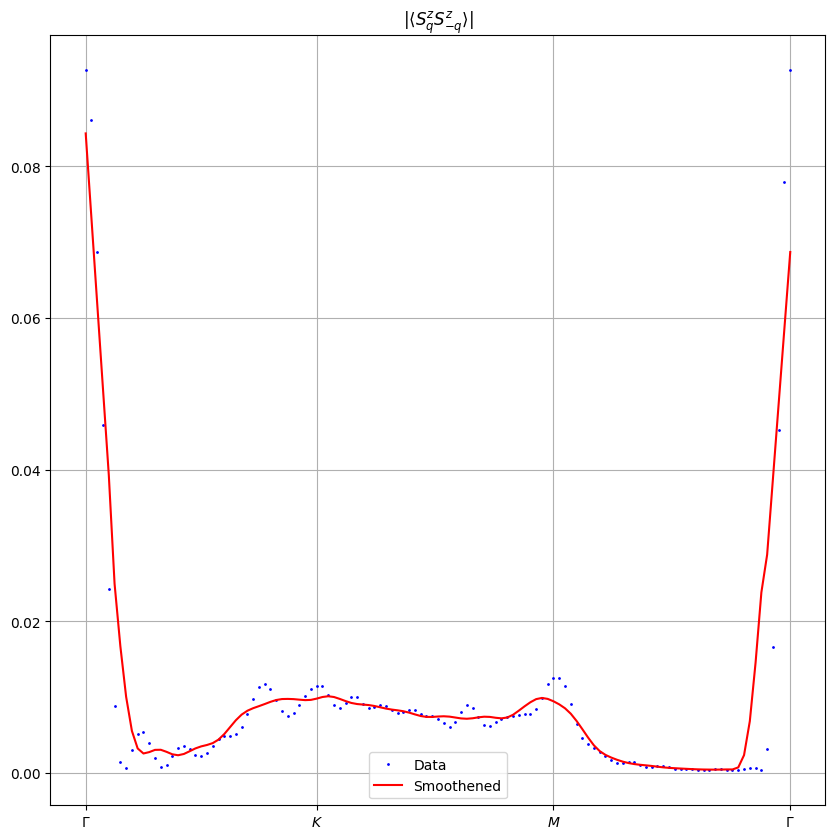

In [85]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
plt.figure(figsize=(10,10))

from scipy.signal import savgol_filter
yhat = savgol_filter(abs(S2_spin), 10, 1)

plt.plot(abs(S2_spin), 'o', c = 'blue', label = 'Data', markersize = 1)
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.xticks(ticks = xticks, labels = xticks_label);
plt.legend()
plt.title(r'$|\langle S^z_q S^z_{-q} \rangle |$')
plt.grid()
plt.show()

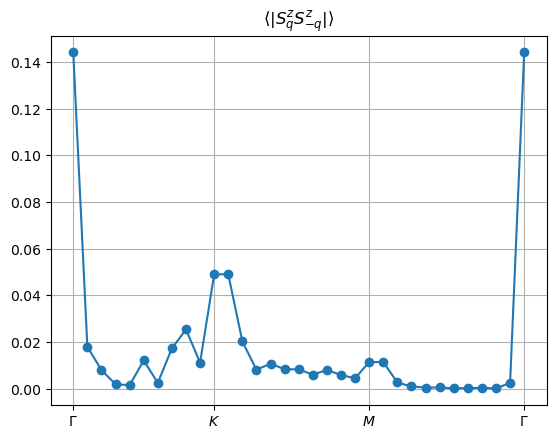

In [207]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
plt.plot(S3_spin, marker = 'o')
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$\langle |S^z_q S^z_{-q}| \rangle $')
plt.grid()

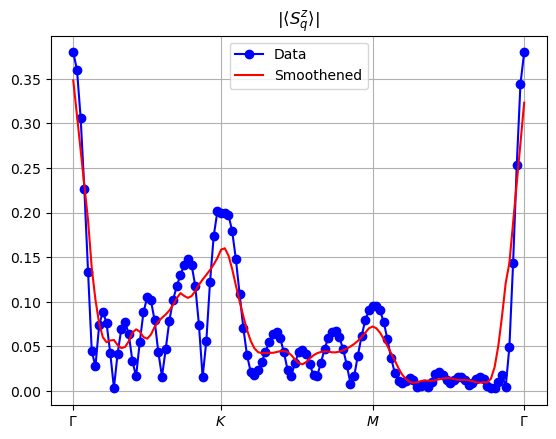

In [266]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
from scipy.signal import savgol_filter
yhat = savgol_filter(abs(structure_factor), 10, 1)

plt.plot(abs(structure_factor), marker = 'o', c = 'blue', label = 'Data')
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.legend()
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$|\langle S^z_q \rangle |$')
plt.grid()

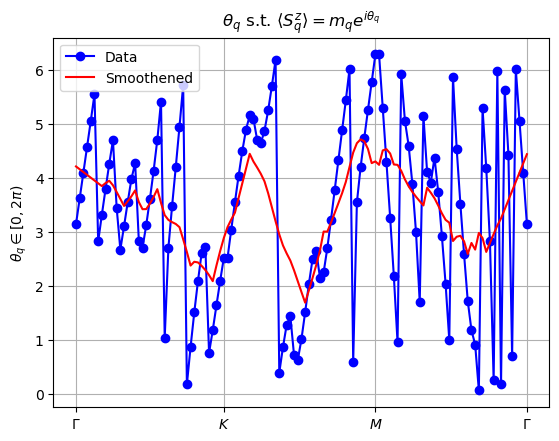

In [271]:
#xticks = [total_K[0], total_K[20], total_K[41], total_K[62]]
xticks = [0, numKpoints, 2*numKpoints + 1, 3*numKpoints + 2]
xticks_label = [r"$\Gamma$", r"$K$", r"$M$",r"$\Gamma$"]
#yval = np.angle(structure_factor)
yval = np.mod(np.angle(structure_factor), 2*np.pi)

yhat = savgol_filter(yval, 15, 1)

plt.plot(yval, marker = 'o', c = 'blue', label = 'Data')
plt.plot(yhat, linestyle = '-', c = 'red', label = 'Smoothened')
plt.legend()
plt.xticks(ticks = xticks, labels = xticks_label);
plt.title(r'$\theta_q$ s.t. $\langle S^z_q \rangle = m_q e^{i\theta_q}$')
plt.ylabel(r"$\theta_q \in [0,2\pi)$")
plt.grid()

# Visualizing unit cell spatial structure

In [228]:
#folders from the raw
# folder = "../data_prathus_runs/periodic Kagome fwd2/raw/h1=1.2800000000000002"
folder = "../data_prathus_runs/periodic Kagome fwd5/raw/h1=2.88"


mainfolder = list(Path(folder).glob('*'))
reps = 0
folders_to_open = []
if len(mainfolder) != 0:
    print("success in finding this folder")
else:
    print('problem')
for foldername in mainfolder:
    if str(foldername)[-4:] == ".npz":
        #print(foldername)
        reps += 1
        folders_to_open.append(foldername)
all_configs = []
all_energies = []
for k in range(len(folders_to_open)):
    file=np.load(folders_to_open[k])
    resps = file['resp']

    for i in range(len(resps)):
        frequency = resps[i][2]
        for freq in range(frequency):
            all_configs.append(resps[i][0])
            all_energies.append(resps[i][1])

all_configs = np.array(all_configs)
file2=np.load(folders_to_open[0])
qubit_variables = np.array(file2["final_nodes"])

success in finding this folder


In [229]:
mags3 = []
eclassical = []
for m in range(len(all_configs)):
    arr = all_configs[m]
    mag3 = np.mean(arr[all_good_down_triangles])
    mags3.append(mag3)
    eclass = np.mean(np.multiply(arr[list_sites_a], arr[list_sites_b]))
    eclassical.append(eclass)

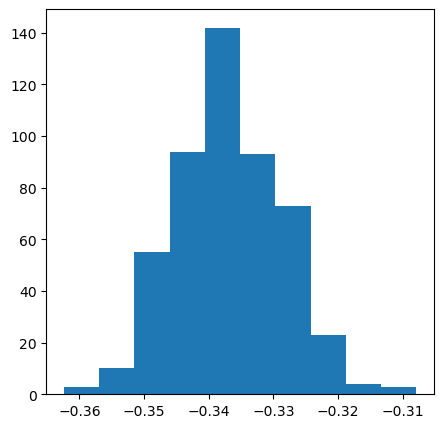

In [231]:
plt.hist(eclassical)
plt.show()

In [223]:
a = np.asarray(mags3)
index = np.abs(a - a.mean()).argmin()
print(index)

0


In [232]:
#finding the configuration with the most satisfied triangles
number_of_trig = []
for cf in range(500):
    best_array = all_configs[cf]
    current_number = 0

    dict_response = {}
    m = 0
    for key in final_qubit_dictionary.keys():
        dict_response.update({key:best_array[m]})
        m += 1

    for r1 in unit_cells.keys():
        three_sites = unit_cells[r1]
        all_data = [dict_response[three_sites[i]] for i in range(3)]
        if all_data == [1,-1,-1]:
            current_number += 1
        elif all_data == [-1,1,-1]:
            current_number += 1
        elif all_data == [-1,-1,1]:
            current_number += 1
    number_of_trig.append(current_number)

index = np.argmax(number_of_trig)
print(index, number_of_trig[index])


97 38


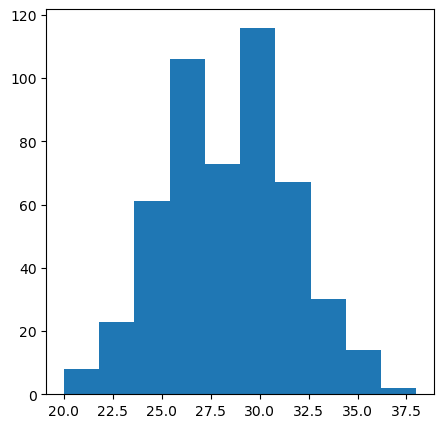

In [233]:
plt.hist(number_of_trig)
plt.show()

only 30 out of 56 triangles are satisfied with the rule.

In [234]:
unit_cells = np.load("./data/unitcells.npy", allow_pickle=True).flat[0]
unit_cells_down = np.load("./data/unitcells_down.npy", allow_pickle=True).flat[0]

#minimum energy element
# index = np.argmin(all_energies)
#avg element
# a = np.asarray(all_energies)
# index = np.abs(a - a.mean()).argmin()
#possibly avg mag = 1/3 for bulk
#index = 6

best_array = all_configs[index]

#make as dict
best_array_dict = {}
for j in range(len(best_array)):
    best_array_dict.update({qubit_variables[j]:best_array[j]})

dict_response = {}
m = 0
for key in final_qubit_dictionary.keys():
    dict_response.update({key:best_array[m]})
    m += 1

locs = []
arrows = []
colors = []
fac = 0.5
all_colors = ["red", "blue", "green", "black"]

vec1 = 2*np.array([1.0, 0.0])
vec2 = 2*np.array([0.5, 0.8660254])

for r1 in unit_cells.keys():
    three_sites = unit_cells[r1]
    r1vec = np.array(r1)
    locs.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254])))
    all_data = [dict_response[three_sites[i]] for i in range(3)]
    if all_data == [1,-1,-1]:
        arrow_triangle = np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [-1,1,-1]:
        arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [-1,-1,1]:
        arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    #+1/3 triangles
    elif all_data == [-1,1,1]:
        arrow_triangle = -np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [1,-1,1]:
        arrow_triangle = -np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [1,1,-1]:
        arrow_triangle = -np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    else :
        arrow_triangle = np.array([0,0])
        col_here = all_colors[3]
        #print(all_data)
    arrows.append(fac*arrow_triangle)
    colors.append(col_here)

locs_down = []
arrows_down = []
colors_down = []
for r1 in unit_cells_down.keys():
    three_sites = unit_cells_down[r1]
    r1vec = np.array(r1)
    locs_down.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(vec2 + np.array([0, 0.8660254])))
    all_data = [dict_response[three_sites[i]] for i in range(3)]
    if all_data == [1,-1,-1]:
        arrow_triangle = np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [-1,1,-1]:
        arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [-1,-1,1]:
        arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    #+1/3 triangles
    elif all_data == [-1,1,1]:
        arrow_triangle = -np.array([1,0])
        col_here = all_colors[0]
    elif all_data == [1,-1,1]:
        arrow_triangle = -np.array([-1/2,np.sqrt(3)/2])
        col_here = all_colors[1]
    elif all_data == [1,1,-1]:
        arrow_triangle = -np.array([-1/2,-np.sqrt(3)/2])
        col_here = all_colors[2]
    else :
        arrow_triangle = np.array([0,0])
        col_here = all_colors[3]
        #print(all_data)
    arrows_down.append(fac*arrow_triangle)
    colors_down.append(col_here)

# locs_down = []
# for r1 in unit_cells_down.keys():
#     three_sites = unit_cells_down[r1]
#     r1vec = np.array(r1)
#     locs_down.append(r1vec[0]*vec1 + r1vec[1]*vec2 + 0.5*(vec2 + np.array([0, 0.8660254])))


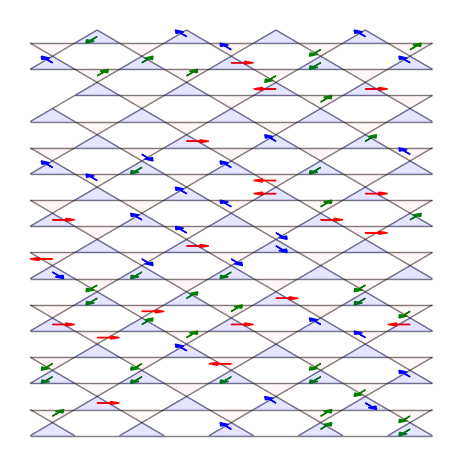

In [237]:
#draw the graph with the specific nodes in red or blue

plt.ion()
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["figure.dpi"]=100

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
options = {"edgecolors": "none", "node_size": 60, "alpha": 1.0}
# edges
nx.draw_networkx_edges(Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# add the arrows
distance1 = -0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
distance2 = 0.5*( np.array([0, 0.8660254]))
distance3 = 0.5*(np.array([1.0, 0.0]) + np.array([0, -0.8660254]))

for i in range(len(locs)):
    #sites_of_triangle = [locs[i] + distance1,locs[i] + distance2, locs[i] + distance3 ]
    #t1 = plt.Polygon(sites_of_triangle, color="black", alpha = 0.1)
    #plt.gca().add_patch(t1)
    plt.arrow(*locs[i], *arrows[i], head_width=0.2, head_length=0.2, fc=colors[i], ec=colors[i], length_includes_head = True)
    sites_of_triangle = [locs[i] + distance1,locs[i] + distance2, locs[i] + distance3 ]
    t1 = plt.Polygon(sites_of_triangle, color="blue", alpha = 0.1)
    ax.add_patch(t1)


for i in range(len(locs_down)):
    plt.arrow(*locs_down[i], *arrows_down[i], head_width=0.2, head_length=0.2, fc=colors_down[i], ec=colors_down[i], length_includes_head = True)
    sites_of_triangle = [locs_down[i] - distance1,locs_down[i] - distance2, locs_down[i] - distance3 ]
    t1 = plt.Polygon(sites_of_triangle, color="red", alpha = 0.03)
    ax.add_patch(t1)
    #ax.scatter(locs_down[i][0], locs_down[i][1], color = 'black', s=10)

# Setting it to how it was looking before.                                                                                                              
f.set_facecolor('w')
plt.tight_layout()
plt.axis("off")
plt.show()

Real space plot, same lattice

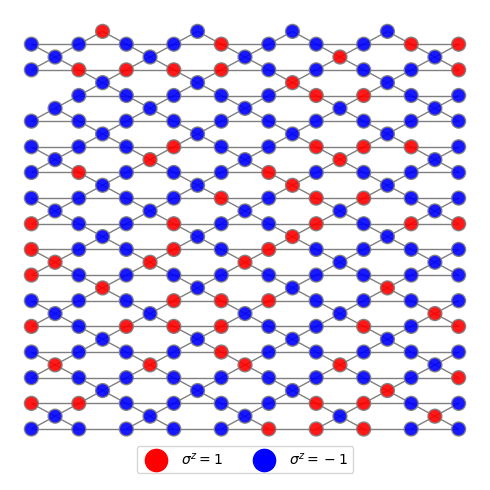

In [236]:

cvals_qu  = [-1, 0, 1]
colors_qu = ["blue","white","red"]

import matplotlib.colors as mc

norm=plt.Normalize(min(cvals_qu),max(cvals_qu))
tuples = list(zip(map(norm,cvals_qu), colors_qu))
cmap = mc.LinearSegmentedColormap.from_list("", tuples)

test_response_qubits = np.array([k for k in final_qubit_dictionary.keys()])
qubits_val = []
qubit_colors = []
for i in range(len(final_qubit_dictionary)):
    qubit_colors.append((dict_response[test_response_qubits[i]] + 1)/2)
    qubits_val.append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 1.0:
    #     qubits_val[0].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == -1.0:
    #     qubits_val[1].append(test_response_qubits[i])
    # if dict_response[test_response_qubits[i]] == 0.0:
    #     qubits_val[2].append(test_response_qubits[i])

#draw the graph with the specific nodes in red or blue

#nx.draw(simplify_Kag_graph, final_qubit_dictionary)
# nodes
ColorLegend = {r'$\sigma^z = 1$' : "red", r'$\sigma^z = -1$' : "blue"
#, r'absent' : "white"
}
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in ColorLegend:
    ax.plot([0],[-2],'o', markersize = 16, color=ColorLegend[label],label=label)
ax.plot([0], [-2], 'o', markersize = 20, markerfacecolor='white', markeredgecolor='white', label='')

options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[0], node_color="tab:red", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[1], node_color="tab:blue", **options, ax=ax)
# nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
# nodelist=qubits_val[2], node_color="white", **options, ax=ax)
nx.draw_networkx_nodes(Kag_graph, final_qubit_dictionary, 
nodelist=qubits_val, node_color=qubit_colors, **options, ax=ax, cmap = cmap)

#draw labels
# label_dict = {}
# for k in test_response_qubits:
#     label_dict.update({k:str(k)})
# nx.draw_networkx_labels(Kag_graph, final_qubit_dictionary, 
# labels = label_dict, ax=ax)

# edges
nx.draw_networkx_edges(Kag_graph, final_qubit_dictionary, width=1.0, alpha=0.5, ax=ax)
# Create a custom legend with colored markers

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(bbox_to_anchor =(0.5,0.0),loc='lower center', ncol=3, fontsize = 10)



plt.tight_layout()
plt.axis("off")
plt.show()

# Perform the Fourier transform over dimers themselves

In [318]:
def Triangle_q_for_record(all_record_configs, qubit_dictionary, qubit_variables, L_Kpoints):
    #L_Kpoints needs to be odd to see the q=0 component
    ascale = 2;
    total_K, kx_vals, ky_vals = momentum_grid_kagome_scale(L_Kpoints, ascale)

    structure_factor = np.zeros(len(total_K))
    S2_spin = np.zeros(len(total_K)) + 1j*np.zeros(len(total_K))
    num_reads = len(all_record_configs)

    vec1 = 2*np.array([1.0, 0.0])
    vec2 = 2*np.array([0.5, 0.8660254])

    for k in range(num_reads):
        response_analyzed = {}
        for j in range(len(qubit_variables)):
            response_analyzed.update({qubit_variables[j]:all_record_configs[k][j]})

        for kp in range(len(total_K)):
            val_K = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            val_mK = np.array([0.0, 0.0]) + 1j*np.array([0.0, 0.0])
            for r1 in qubit_dictionary.keys():
                kpoint = total_K[kp]
                three_sites = qubit_dictionary[r1]
                r1vec_temp = np.array(r1)
                r1vec = r1vec_temp[0]*vec1 + r1vec_temp[1]*vec2 + 0.5*(np.array([1.0, 0.0]) + np.array([0, 0.8660254]))
                all_data = [response_analyzed[three_sites[i]] for i in range(3)]
                if all_data == [1,-1,-1]:
                    arrow_triangle = np.array([1,0])
                elif all_data == [-1,1,-1]:
                    arrow_triangle = np.array([-1/2,np.sqrt(3)/2])
                elif all_data == [-1,-1,1]:
                    arrow_triangle = np.array([-1/2,-np.sqrt(3)/2])
                else :
                    arrow_triangle = np.array([0,0])
                #partA = response_analyzed[three_sites[0]]*np.array([1,0])
                #partB = response_analyzed[three_sites[1]]*np.array([-1/2,np.sqrt(3)/2])
                #partC = response_analyzed[three_sites[2]]*np.array([-1/2, -np.sqrt(3)/2])
                #arrow_triangle = partA + partB + partC
                val_K += np.exp(1j*np.dot(kpoint, r1vec))*(arrow_triangle)
                val_mK += np.exp(-1j*np.dot(kpoint, r1vec))*(arrow_triangle)
            val_K = val_K/len(qubit_dictionary)
            val_mK = val_mK/len(qubit_dictionary)
            structure_factor[kp] += np.linalg.norm(val_K)
            S2_spin[kp] += np.dot(val_K,val_mK)
        if num_reads != 1:
            if k % (num_reads // 10) == 0:
                print("Done with reads: ", k)

    structure_factor = structure_factor / num_reads
    S2_spin = S2_spin / num_reads

    return total_K, kx_vals, ky_vals, S2_spin, structure_factor
    

In [322]:
numKpoints = 37
#feed_in_configs = np.array([all_configs[0]])
feed_in_configs = all_configs[0:100]
total_K, kx_vals, ky_vals, S2_spin, structure_factor = Triangle_q_for_record(feed_in_configs, unit_cells, qubit_variables, numKpoints)

Done with reads:  0
Done with reads:  10
Done with reads:  20
Done with reads:  30
Done with reads:  40
Done with reads:  50
Done with reads:  60
Done with reads:  70
Done with reads:  80
Done with reads:  90


Plotting the bare Q-space data - what is the Brillouin Zone for this new lattice?? It is half the BZ of the original kagome, because the translation vectors are twice in length.

Text(0.5, 1.0, '$\\langle|\\vec{\\Phi}(q)|\\rangle$')

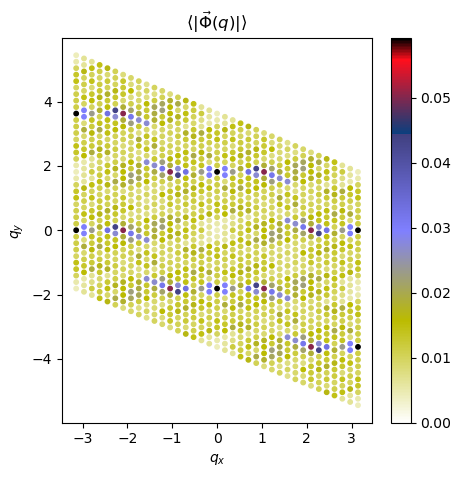

In [326]:
cmap = plt.cm.get_cmap('gist_stern_r')
#finalSQ = np.absolute(S2_spin) - np.absolute(structure_factor)*np.absolute(structure_factor_mK)
finalSQ = abs(S2_spin)
#finalSQ = structure_factor
#finalSQ = final_spin_Q2 - final_spin_Q**2
norm = plt.Normalize(0,np.max(finalSQ))

plt.scatter(kx_vals, ky_vals, s=10, c=finalSQ, cmap=cmap, norm = norm)
plt.colorbar()

plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.title(r'$\langle|\vec{\Phi}(q)|\rangle$')

Interpolation

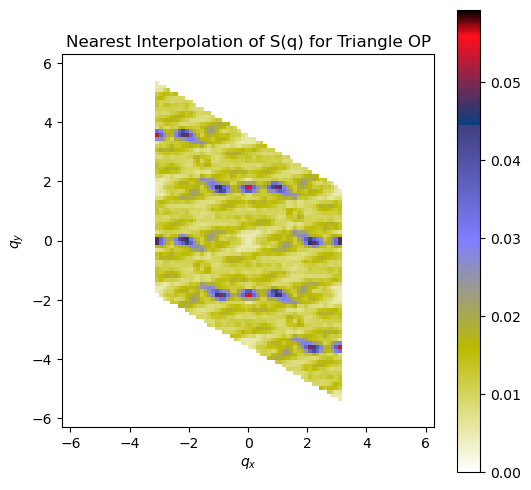

In [329]:
from scipy.interpolate import griddata
xlim = np.linspace(-2*np.pi, 2*np.pi, 100)
ylim = np.linspace(-2*np.pi, 2*np.pi, 100)
#xlim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
#ylim = np.hstack((np.linspace(-2*np.pi, -0.5, 50), np.linspace(0.5, 2*np.pi, 50)))
grid_x, grid_y = np.meshgrid(xlim, ylim, indexing='ij')
points = total_K
#values = structure_factor
values = np.absolute(S2_spin)
grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')
#possible methods: nearest, square, cubic


#plt.subplot(221)
#plt.imshow(func(grid_x, grid_y).T, extent=(0, 1, 0, 1), origin='lower')
#plt.plot(points[:, 0], points[:, 1], 'k.', ms=1)   # data
#plt.title('Original')
extent_plot = (-2*np.pi, 2*np.pi, -2*np.pi, 2*np.pi)
norm = plt.Normalize(0,np.max(values))

cmap = plt.cm.get_cmap('gist_stern_r')
plt.imshow(grid_z0.T, extent=extent_plot, origin='lower', cmap = cmap, norm = norm)
plt.title('Nearest Interpolation of S(q) for Triangle OP')
plt.colorbar()
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
# theta_list = [2*np.pi*i/6 for i in range(7)]
# lside = 4*np.pi/3
# for j in range(6):
#     plt.plot([lside*np.cos(theta_list[j]), lside*np.cos(theta_list[j+1])],
#      [lside*np.sin(theta_list[j]), lside*np.sin(theta_list[j+1])], 'k-.', lw=2, alpha = 0.4)
plt.gcf().set_size_inches(6, 6)
plt.show()

Shows some kind of nematic order - due to lattice periodicity in a given direction

# preprocess and measure of specific Q points

In [12]:
nodes_period=[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 30, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 63, 64, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 93, 95, 96, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 127, 128, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 159, 160, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 191, 192, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 220, 223, 224, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 252, 255, 256, 263, 264, 265, 266, 267, 268, 269, 270, 271, 279, 286, 296, 297, 298, 299, 300, 301, 302, 303, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 336, 337, 338, 339, 340, 341, 342, 343, 351, 360, 361, 362, 363, 364, 365, 366, 367, 382, 400, 401, 402, 403, 404, 405, 406, 407, 412, 424, 425, 426, 427, 428, 429, 430, 431, 464, 465, 466, 467, 468, 469, 470, 471, 472, 488, 489, 490, 491, 492, 493, 494, 495, 511, 525, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 567]

In [40]:
K = (4*np.pi/3)*np.array([1, 0])
M = (4*np.pi/3)*(np.array([1, 0]) + np.array([np.cos(2*np.pi/6), np.sin(2*np.pi/6)]))/2

n_vars = len(nodes_period)
n_sites = len(final_qubit_dictionary)
interaction_matrix_K = np.zeros((n_vars, n_vars)) + 1j*np.zeros((n_vars, n_vars))
interaction_matrix_M = np.zeros((n_vars, n_vars)) + 1j*np.zeros((n_vars, n_vars))

for i in range(n_vars):
    for j in range(n_vars):
        if nodes_period[i] in final_qubit_dictionary and nodes_period[j] in final_qubit_dictionary:
            rdist = final_qubit_dictionary[nodes_period[i]] - final_qubit_dictionary[nodes_period[j]]
            interaction_matrix_K[i,j] = np.exp(1j*np.dot(K, rdist))
            interaction_matrix_M[i,j] = np.exp(1j*np.dot(M, rdist))
        else:
            interaction_matrix_K[i,j] = 0.0
            interaction_matrix_M[i,j] = 0.0

#then, the K or M value is simply 
#example, one config
#it would be: np.array(np.load(...filename...)['resp'][index][0])
vec = np.array(np.load(folders_to_open[0])['resp'][1][0])
val = np.abs(np.dot(vec, np.dot(interaction_matrix_K, np.transpose(vec)))/(n_sites**2))
print(val)

0.06178669815033453


# some cells for processing easily

In [194]:
sublatt_dict={0: 'A', 7: 'B', 8: 'A', 9: 'A', 10: 'A', 11: 'A', 12: 'B', 13: 'B', 14: 'B', 15: 'B', 24: 'B', 40: 'B', 41: 'B', 42: 'B', 43: 'B', 44: 'A', 45: 'A', 46: 'A', 47: 'A', 48: 'B', 49: 'B', 50: 'B', 51: 'B', 52: 'A', 53: 'A', 54: 'A', 55: 'A', 63: 'B', 64: 'B', 71: 'A', 72: 'A', 73: 'A', 74: 'A', 75: 'A', 76: 'B', 77: 'B', 78: 'B', 79: 'B', 80: 'A', 81: 'A', 82: 'A', 83: 'A', 84: 'B', 85: 'B', 86: 'B', 87: 'B', 88: 'B', 95: 'B', 96: 'A', 104: 'B', 105: 'B', 106: 'B', 107: 'B', 108: 'A', 109: 'A', 110: 'A', 111: 'A', 112: 'B', 113: 'B', 114: 'B', 115: 'B', 116: 'A', 117: 'A', 118: 'A', 119: 'A', 120: 'A', 127: 'A', 128: 'B', 135: 'B', 136: 'A', 137: 'A', 138: 'A', 139: 'A', 140: 'B', 141: 'B', 142: 'B', 143: 'B', 144: 'A', 145: 'A', 146: 'A', 147: 'A', 148: 'B', 149: 'B', 150: 'B', 152: 'B', 159: 'B', 160: 'A', 168: 'B', 169: 'B', 170: 'B', 171: 'B', 172: 'A', 173: 'A', 174: 'A', 175: 'A', 176: 'B', 177: 'B', 178: 'B', 179: 'B', 180: 'A', 181: 'A', 182: 'A', 183: 'A', 191: 'B', 200: 'A', 201: 'A', 202: 'A', 203: 'A', 204: 'B', 205: 'B', 206: 'B', 207: 'B', 208: 'A', 209: 'A', 210: 'A', 211: 'A', 212: 'B', 213: 'B', 214: 'B', 215: 'B', 216: 'B', 223: 'B', 232: 'B', 233: 'B', 234: 'B', 235: 'B', 236: 'A', 237: 'A', 238: 'A', 239: 'A', 240: 'B', 241: 'B', 242: 'B', 243: 'B', 244: 'A', 245: 'A', 246: 'A', 247: 'A', 264: 'A', 265: 'A', 266: 'A', 267: 'A', 268: 'B', 269: 'B', 270: 'B', 271: 'B', 296: 'C', 297: 'C', 298: 'C', 299: 'C', 300: 'C', 301: 'C', 302: 'C', 303: 'C', 307: 'A', 310: 'A', 311: 'A', 318: 'B', 319: 'B', 324: 'A', 336: 'C', 337: 'C', 338: 'C', 339: 'C', 340: 'C', 341: 'C', 342: 'C', 343: 'C', 360: 'C', 361: 'C', 362: 'C', 363: 'C', 364: 'C', 365: 'C', 366: 'C', 367: 'C', 400: 'C', 401: 'C', 402: 'C', 403: 'C', 404: 'C', 405: 'C', 406: 'C', 407: 'C', 424: 'C', 425: 'C', 426: 'C', 427: 'C', 428: 'C', 429: 'C', 430: 'C', 431: 'C', 464: 'C', 465: 'C', 466: 'C', 467: 'C', 468: 'C', 469: 'C', 470: 'C', 471: 'C', 488: 'C', 489: 'C', 490: 'C', 491: 'C', 492: 'C', 493: 'C', 494: 'C', 495: 'C', 528: 'C', 529: 'C', 530: 'C', 531: 'C', 532: 'C', 533: 'C', 534: 'C', 535: 'C', 536: 'A', 537: 'A', 538: 'A', 539: 'A', 543: 'A', 550: 'A', 551: 'B', 552: 'C', 553: 'C', 554: 'C', 555: 'C', 556: 'C', 557: 'C', 558: 'C', 559: 'C'}
toremove=[
    63,191,551,223,159,95,7,
    324,120,310,311,307,160,96,0
]
sublatt_dict_trunc=sublatt_dict.copy()
for qubit in toremove:
    sublatt_dict_trunc.pop(qubit)
    
toremove2=[71,556,127,557,550,558,543,559,539,555,538,554,537,553,536,552,
           64,300,128,301,318,302,319,303,216,299,152,298,88, 297,24, 296,
           87,135,215,271,207,143,79, 15, 80, 144,208,264,200,136,72,8

]
sublatt_dict_truncer=sublatt_dict_trunc.copy()
for qubit in toremove2:
    sublatt_dict_truncer.pop(qubit)

Alist=[]
Blist=[]
Clist=[]
for key in sublatt_dict_trunc.keys():
    if sublatt_dict_trunc[key] == "A":
        Alist.append(key)
    if sublatt_dict_trunc[key] == "B":
        Blist.append(key)
    if sublatt_dict_trunc[key] == "C":
        Clist.append(key)
print("number of points per sublattice")
print("A, B, C")
print(len(Alist),len(Blist),len(Clist))

Alist2=[]
Blist2=[]
Clist2=[]
for key in sublatt_dict_truncer.keys():
    if sublatt_dict_truncer[key] == "A":
        Alist2.append(key)
    if sublatt_dict_truncer[key] == "B":
        Blist2.append(key)
    if sublatt_dict_truncer[key] == "C":
        Clist2.append(key)
print("number of points per sublattice")
print("A, B, C")
print(len(Alist2),len(Blist2),len(Clist2))
allsites=sublatt_dict.keys()
allsites_down=sublatt_dict_trunc.keys()
allsites_down_good=sublatt_dict_truncer.keys()

twochains_period=[(204, 382), (220, 342), (45, 412), (93, 404), (30, 488), (14, 472), (238, 511), (286, 471), (143, 525), (123, 533), (239, 567), (279, 535), (252, 343), (268, 351), (135, 541), (24, 312), (88, 313), (152, 314), (216, 315), (319, 256), (318, 192), (128, 325), (64, 316), (536, 39), (537, 103), (538, 167), (539, 231), (543, 255), (550, 199), (71, 548), (0, 320), (324, 56), (96, 321), (120, 317), (160, 322), (310, 184), (307, 224), (311, 248), (7, 544), (63, 540), (95, 545), (159, 546), (191, 542), (223, 547), (551, 263)]
nodes_period=[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 30, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 63, 64, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 93, 95, 96, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 127, 128, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 159, 160, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 191, 192, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 220, 223, 224, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 252, 255, 256, 263, 264, 265, 266, 267, 268, 269, 270, 271, 279, 286, 296, 297, 298, 299, 300, 301, 302, 303, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 336, 337, 338, 339, 340, 341, 342, 343, 351, 360, 361, 362, 363, 364, 365, 366, 367, 382, 400, 401, 402, 403, 404, 405, 406, 407, 412, 424, 425, 426, 427, 428, 429, 430, 431, 464, 465, 466, 467, 468, 469, 470, 471, 472, 488, 489, 490, 491, 492, 493, 494, 495, 511, 525, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 567]
all_couplers_from_site = [(0, 296), (0, 40), (7, 552), (7, 47), (8, 12), (8, 296), (8, 336), (8, 24), (9, 13), (9, 360), (9, 12), (9, 400), (10, 14), (10, 424), (10, 13), (10, 464), (11, 15), (11, 488), (11, 14), (11, 528), (12, 360), (12, 336), (13, 424), (13, 400), (14, 488), (14, 464), (15, 552), (15, 528), (15, 536), (24, 296), (40, 296), (40, 44), (40, 340), (41, 360), (41, 45), (41, 404), (41, 44), (42, 424), (42, 46), (42, 468), (42, 45), (43, 488), (43, 47), (43, 532), (43, 46), (44, 360), (44, 340), (45, 424), (45, 404), (46, 488), (46, 468), (47, 552), (47, 532), (48, 300), (48, 52), (48, 336), (48, 324), (49, 400), (49, 52), (49, 364), (49, 53), (50, 464), (50, 53), (50, 428), (50, 54), (51, 528), (51, 54), (51, 492), (51, 55), (52, 336), (52, 364), (53, 400), (53, 428), (54, 464), (54, 492), (55, 556), (55, 528), (55, 63), (63, 556), (64, 300), (64, 80), (71, 556), (71, 87), (72, 76), (72, 297), (72, 340), (72, 88), (73, 77), (73, 361), (73, 76), (73, 404), (74, 78), (74, 425), (74, 77), (74, 468), (75, 79), (75, 489), (75, 78), (75, 532), (76, 361), (76, 340), (77, 425), (77, 404), (78, 489), (78, 468), (79, 553), (79, 532), (79, 537), (80, 84), (80, 300), (80, 337), (81, 84), (81, 401), (81, 85), (81, 364), (82, 85), (82, 465), (82, 86), (82, 428), (83, 86), (83, 529), (83, 87), (83, 492), (84, 337), (84, 364), (85, 401), (85, 428), (86, 465), (86, 492), (87, 556), (87, 529), (88, 297), (95, 553), (95, 111), (96, 297), (96, 104), (104, 297), (104, 108), (104, 341), (105, 361), (105, 109), (105, 405), (105, 108), (106, 425), (106, 110), (106, 469), (106, 109), (107, 489), (107, 111), (107, 533), (107, 110), (108, 361), (108, 341), (109, 425), (109, 405), (110, 489), (110, 469), (111, 553), (111, 533), (112, 301), (112, 116), (112, 337), (112, 120), (113, 401), (113, 116), (113, 365), (113, 117), (114, 465), (114, 117), (114, 429), (114, 118), (115, 529), (115, 118), (115, 493), (115, 119), (116, 337), (116, 365), (117, 401), (117, 429), (118, 465), (118, 493), (119, 557), (119, 529), (120, 301), (127, 557), (127, 135), (128, 301), (128, 144), (135, 557), (135, 530), (135, 147), (136, 140), (136, 298), (136, 341), (136, 152), (137, 141), (137, 362), (137, 140), (137, 405), (138, 142), (138, 426), (138, 141), (138, 469), (139, 143), (139, 490), (139, 142), (139, 533), (140, 362), (140, 341), (141, 426), (141, 405), (142, 490), (142, 469), (143, 554), (143, 533), (143, 538), (144, 148), (144, 301), (144, 338), (145, 148), (145, 402), (145, 149), (145, 365), (146, 149), (146, 466), (146, 150), (146, 429), (147, 150), (147, 530), (147, 493), (148, 338), (148, 365), (149, 402), (149, 429), (150, 466), (150, 493), (152, 298), (159, 554), (159, 175), (160, 298), (160, 168), (168, 298), (168, 172), (168, 342), (169, 362), (169, 173), (169, 406), (169, 172), (170, 426), (170, 174), (170, 470), (170, 173), (171, 490), (171, 175), (171, 534), (171, 174), (172, 362), (172, 342), (173, 426), (173, 406), (174, 490), (174, 470), (175, 554), (175, 534), (176, 302), (176, 180), (176, 338), (176, 310), (177, 402), (177, 180), (177, 366), (177, 181), (178, 466), (178, 181), (178, 430), (178, 182), (179, 530), (179, 182), (179, 494), (179, 183), (180, 338), (180, 366), (181, 402), (181, 430), (182, 466), (182, 494), (183, 558), (183, 530), (183, 191), (191, 558), (200, 204), (200, 299), (200, 342), (200, 216), (201, 205), (201, 363), (201, 204), (201, 406), (202, 206), (202, 427), (202, 205), (202, 470), (203, 207), (203, 491), (203, 206), (203, 534), (204, 363), (204, 342), (205, 427), (205, 406), (206, 491), (206, 470), (207, 555), (207, 534), (207, 539), (208, 212), (208, 302), (208, 339), (208, 318), (209, 212), (209, 403), (209, 213), (209, 366), (210, 213), (210, 467), (210, 214), (210, 430), (211, 214), (211, 531), (211, 215), (211, 494), (212, 339), (212, 366), (213, 403), (213, 430), (214, 467), (214, 494), (215, 558), (215, 531), (215, 550), (216, 299), (223, 555), (223, 239), (232, 299), (232, 236), (232, 343), (232, 307), (233, 363), (233, 237), (233, 407), (233, 236), (234, 427), (234, 238), (234, 471), (234, 237), (235, 491), (235, 239), (235, 535), (235, 238), (236, 363), (236, 343), (237, 427), (237, 407), (238, 491), (238, 471), (239, 555), (239, 535), (240, 303), (240, 244), (240, 339), (240, 311), (241, 367), (241, 245), (241, 403), (241, 244), (242, 431), (242, 246), (242, 467), (242, 245), (243, 495), (243, 247), (243, 531), (243, 246), (244, 367), (244, 339), (245, 431), (245, 403), (246, 495), (246, 467), (247, 559), (247, 531), (247, 551), (264, 268), (264, 343), (264, 303), (264, 319), (265, 268), (265, 407), (265, 269), (265, 367), (266, 269), (266, 471), (266, 270), (266, 431), (267, 270), (267, 535), (267, 271), (267, 495), (268, 343), (268, 367), (269, 407), (269, 431), (270, 471), (270, 495), (271, 535), (271, 559), (271, 543), (299, 307), (300, 324), (302, 318), (302, 310), (303, 319), (303, 311), (536, 552), (537, 553), (538, 554), (539, 555), (543, 559), (550, 558), (551, 559)]
all_sites = []
for n in range(len(list(sublatt_dict.keys()))):
    qubit = list(sublatt_dict.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_sites.append(index)

all_down_triangles = []
for n in range(len(list(sublatt_dict_trunc.keys()))):
    qubit = list(sublatt_dict_trunc.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_down_triangles.append(index)

all_good_down_triangles = []
for n in range(len(list(sublatt_dict_truncer.keys()))):
    qubit = list(sublatt_dict_truncer.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_good_down_triangles.append(index)
list_sites_a = []
list_sites_b = []
actual_couples_to_measure = []
for n in range(len(list(sublatt_dict_truncer.keys()))):
    qubit = list(sublatt_dict_truncer.keys())[n]
    for tuple_couple in all_couplers_from_site:
        if qubit == tuple_couple[0] or qubit == tuple_couple[1]:
            actual_couples_to_measure.append(tuple_couple)

del_dup_couples = [*set(actual_couples_to_measure)]
for i in range(len(del_dup_couples)):
    asite = np.where(np.array(nodes_period) == del_dup_couples[i][0])[0][0]
    list_sites_a.append(asite)
    bsite = np.where(np.array(nodes_period) == del_dup_couples[i][1])[0][0]
    list_sites_b.append(bsite)

number of points per sublattice
A, B, C
72 72 72
number of points per sublattice
A, B, C
56 56 56
